In [1]:
! cd $HOME/ICAROS; git remote add bpalmeiro https://github.com/bpalmeiro/ICAROS.git; git fetch bpalmeiro; git checkout bpalmeiro/automatic_script; cd -;

remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 339 (delta 190), reused 197 (delta 163), pack-reused 110
Receiving objects: 100% (339/339), 48.79 KiB | 2.03 MiB/s, done.
Resolving deltas: 100% (245/245), completed with 6 local objects.
From https://github.com/bpalmeiro/ICAROS
 * [new branch]      automatic_script -> bpalmeiro/automatic_script
 * [new branch]      krcalib2.0       -> bpalmeiro/krcalib2.0
 * [new branch]      master           -> bpalmeiro/master
Note: checking out 'bpalmeiro/automatic_script'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -

In [2]:
! cd $HOME; git clone https://github.com/nextic/ICAROS.git $HOME/ICAROS_master; cd -;

Cloning into '/home/jovyan/ICAROS_master'...
remote: Enumerating objects: 1457, done.
remote: Total 1457 (delta 0), reused 0 (delta 0), pack-reused 1457
Receiving objects: 100% (1457/1457), 1.71 MiB | 10.47 MiB/s, done.
Resolving deltas: 100% (851/851), done.
/home/jovyan/ICAROS_NBS


In [55]:
import os
import copy
from pytest        import mark
from numpy.testing import assert_raises

from invisible_cities.core.configure       import configure
from invisible_cities.reco.corrections_new import read_maps
from invisible_cities.reco.corrections_new import ASectorMap

from krcal.map_builder.map_builder_functions import *
from krcal.map_builder.checking_functions    import AbortingMapCreation
from krcal.core       .xy_maps_functions     import draw_xy_maps

In [4]:
import logging
import warnings
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

In [5]:
! wget https://www.dropbox.com/s/025si49skkv6n49/kdst_7517_LB_0-100_TestMapScript.h5
! wget https://www.dropbox.com/s/3ky8js2yekh4sqw/kr_emap_xy_100_100_r_6573_time.h5
! wget https://www.dropbox.com/s/5n9gj9wjcz70na7/z_dst_LB_mean_ref.h5

--2019-10-08 14:21:55--  https://www.dropbox.com/s/025si49skkv6n49/kdst_7517_LB_0-100_TestMapScript.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/025si49skkv6n49/kdst_7517_LB_0-100_TestMapScript.h5 [following]
--2019-10-08 14:21:55--  https://www.dropbox.com/s/raw/025si49skkv6n49/kdst_7517_LB_0-100_TestMapScript.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd16fe36bd8343b8d35133316dd.dl.dropboxusercontent.com/cd/0/inline/AqC0aTnqrJGCBmWBCMFvv7_28LiakjClMEwMfM5KfSjpD6olo9s3mtVgvRlP2OqntmfrYUqRpJheubX4O73MFC2FeNgfrq4BDnXGyhDCWaGd2ZPt9Wta2pIibujfThZ1Ho0/file# [following]
--2019-10-08 14:21:55--  https://ucd16fe36bd8343b8d35133316dd.dl.dropboxusercontent.com/cd/0/inline/AqC0aTnqrJGCBmWBCMFvv7_28LiakjClMEwMfM5KfSjpD

In [32]:
folder_test_dst = './'
test_dst_file   = 'kdst_7517_LB_0-100_TestMapScript.h5'
file_bootstrap_map = 'kr_emap_xy_100_100_r_6573_time.h5'
output_maps_tmdir = './'
map_file_out   = os.path.join(output_maps_tmdir, 'test_out_map.h5')
histo_file_out = os.path.join(output_maps_tmdir, 'test_out_histo.h5')

In [52]:
default_n_bins = 15

In [53]:
config = configure('maps $ICARO/krcal/map_builder/config_LBphys.conf'.split())
print(folder_test_dst + test_dst_file)
config.update(dict(folder       = folder_test_dst   ,
                   file_in      = test_dst_file,
                   file_out_map = map_file_out,
                   file_out_hists = histo_file_out,
                   default_n_bins = default_n_bins,
                   file_bootstrap_map = file_bootstrap_map,
                  ref_Z_histogram    = dict(
                    ref_histo_file = 'z_dst_LB_mean_ref.h5',
                    key_Z_histo    = 'histo_Z_dst')                                                  ))
automatic_test(config.as_namespace)

./kdst_7517_LB_0-100_TestMapScript.h5


In [59]:
config_n = config.as_namespace
dst, bootstrapmap, ref_histos  = load_data(input_path         = config_n.folder            ,
                                               input_dsts         = config_n.file_in           ,
                                               file_bootstrap_map = config_n.file_bootstrap_map,
                                               quality_ranges     = config_n.quality_ranges    ,
                                               **config_n.ref_Z_histogram                      )

with pd.HDFStore(config_n.file_out_hists, "w", complib=str("zlib"), complevel=4) as store_hist:
    dst_passed_cut = apply_cuts(dst              = dst                    ,
                                    S1_signal        = type_of_signal.nS1     ,
                                    nS1_eff_interval = (config_n.nS1_eff_min    ,
                                                        config_n.nS1_eff_max)   ,
                                    store_hist_s1    = store_hist             ,
                                    ns1_histo_params = config_n.ns1_histo_params,
                                    S2_signal        = type_of_signal.nS2     ,
                                    nS2_eff_interval = (config_n.nS2_eff_min    ,
                                                        config_n.nS2_eff_max)   ,
                                    store_hist_s2    = store_hist             ,
                                    ns2_histo_params = config_n.ns2_histo_params,
                                    nsigmas_Zdst     = config_n.nsigmas_Zdst    ,
                                    ref_Z_histo      = ref_histos.
                                                           Z_dist_hist,
                                    bootstrapmap     = bootstrapmap           ,
                                    band_sel_params  = config_n.band_sel_params )

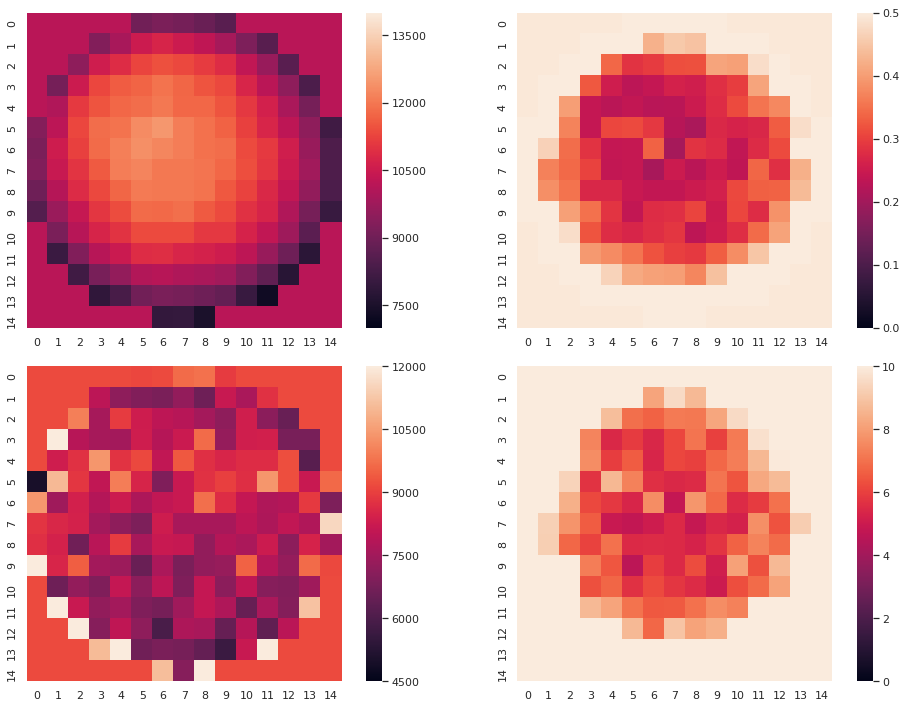

In [54]:
out_map = read_maps(map_file_out)
draw_xy_maps(out_map,
             e0lims  = (7000, 14000),
             ltlims  = (4500, 12000),
             eulims  = (0.0,  0.5),
             lulims  = (0, 10),
             figsize=(14,10))

In [10]:
# old notebook

In [19]:
import sys
import numpy as np
sys.path.append('/home/jovyan')

In [30]:
from  invisible_cities.io.dst_io              import load_dsts, load_dst
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
import sys
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import warnings
import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from ICAROS_master.krcal.core.core_functions                import time_delta_from_time
from ICAROS_master.krcal.core.core_functions                import phirad_to_deg
from ICAROS_master.krcal.core.core_functions                import NN
from ICAROS_master.krcal.core.core_functions                import timeit
from ICAROS_master.krcal.core.core_functions                import data_frames_are_identical

from ICAROS_master.krcal.core.io_functions                  import filenames_from_paths
from ICAROS_master.krcal.core.io_functions                  import filenames_from_list
from ICAROS_master.krcal.core.io_functions                  import kdst_write
from ICAROS_master.krcal.core.io_functions                  import write_maps
from ICAROS_master.krcal.core.io_functions                  import read_maps
from ICAROS_master.krcal.core.io_functions                  import write_maps_ts
from ICAROS_master.krcal.core.io_functions                  import read_maps_ts

from ICAROS_master.krcal.core.ranges_and_bins_functions     import kr_ranges_and_bins

from ICAROS_master.krcal.core.histo_functions               import h1, h1d, h2, h2d, profile1d, plot_histo
from ICAROS_master.krcal.core.kr_types                      import PlotLabels, FitType

from ICAROS_master.krcal.core.s1s2_functions                import s1d_from_dst
from ICAROS_master.krcal.core.s1s2_functions                import s2d_from_dst
from ICAROS_master.krcal.core.s1s2_functions                import plot_s1histos
from ICAROS_master.krcal.core.s1s2_functions                import plot_s2histos
from ICAROS_master.krcal.core.s1s2_functions                import energy_time_profile
from ICAROS_master.krcal.core.s1s2_functions                import energy_X_profile

from ICAROS_master.krcal.core.plt_functions                 import plot_xy_density
from ICAROS_master.krcal.core.plt_functions                 import plot_s1_vs_z
from ICAROS_master.krcal.core.plt_functions                 import plot_s2_vs_z
from ICAROS_master.krcal.core.plt_functions                 import plot_s2_vs_s1
from ICAROS_master.krcal.core.plt_functions                 import plot_q_vs_s2
from ICAROS_master.krcal.core.plt_functions                 import plot_energy_distributions
from ICAROS_master.krcal.core.plt_functions                 import plot_energy_vs_t

from ICAROS_master.krcal.core.selection_functions           import event_map_df
from ICAROS_master.krcal.core.selection_functions           import select_rphi_sectors_df
from ICAROS_master.krcal.core.selection_functions           import select_xy_sectors_df
from ICAROS_master.krcal.core.selection_functions           import get_time_series_df
from ICAROS_master.krcal.core.fitmap_functions              import time_fcs_df
from ICAROS_master.krcal.core.fitmap_functions              import fit_fcs_in_rphi_sectors_df
from ICAROS_master.krcal.core.fitmap_functions              import fit_map_xy_df

from ICAROS_master.krcal.core.map_functions                 import tsmap_from_fmap
from ICAROS_master.krcal.core.map_functions                 import amap_from_tsmap
from ICAROS_master.krcal.core.map_functions                 import relative_errors
from ICAROS_master.krcal.core.map_functions                 import amap_average
from ICAROS_master.krcal.core.map_functions                 import amap_max
from ICAROS_master.krcal.core.map_functions                 import amap_min
from ICAROS_master.krcal.core.map_functions                 import amap_replace_nan_by_mean
from ICAROS_master.krcal.core.map_functions                 import amap_replace_nan_by_zero
from ICAROS_master.krcal.core.map_functions                 import regularize_maps
from ICAROS_master.krcal.core.map_functions                 import get_maps_from_tsmap
from ICAROS_master.krcal.core.map_functions                 import map_average
from ICAROS_master.krcal.core.map_functions                 import add_mapinfo

from ICAROS_master.krcal.core.xy_maps_functions             import draw_xy_maps
from ICAROS_master.krcal.core.xy_maps_functions             import draw_xy_map
from ICAROS_master.krcal.core.xy_maps_functions             import draw_xy_maps_ts

from ICAROS_master.krcal.core.rphi_maps_functions           import draw_rphi_maps
from ICAROS_master.krcal.core.rphi_maps_functions           import draw_rphi_map
from ICAROS_master.krcal.core.rphi_maps_functions           import draw_rphi_maps_ts
from ICAROS_master.krcal.core.rphi_maps_functions           import draw_wedges
from ICAROS_master.krcal.core.rphi_maps_functions           import define_rphi_sectors
from ICAROS_master.krcal.core.rphi_maps_functions           import rphi_sector_map_def

from ICAROS_master.krcal.core.correction_functions          import e0_rphi_correction
from ICAROS_master.krcal.core.correction_functions          import e0_xy_correction
from ICAROS_master.krcal.core.correction_functions          import lt_xy_correction
from ICAROS_master.krcal.core.correction_functions          import e0_xy_correction_ts
from ICAROS_master.krcal.core.correction_functions          import lt_xy_correction_ts
from ICAROS_master.krcal.core.correction_functions          import lt_rphi_correction
from ICAROS_master.krcal.core.correction_functions          import lt_rphi_correction_ts
from ICAROS_master.krcal.core.correction_functions          import e0_rphi_correction_ts
from ICAROS_master.krcal.core.correction_functions          import e0_rphi_correction_ts

from ICAROS_master.krcal.core.fit_lt_histograms             import plot_time_fcs
from ICAROS_master.krcal.core.fit_energy_functions          import fit_energy
from ICAROS_master.krcal.core.fit_energy_functions          import plot_fit_energy
from ICAROS_master.krcal.core.fit_energy_functions          import print_fit_energy
from ICAROS_master.krcal.core.fit_energy_functions          import resolution_r_z
from ICAROS_master.krcal.core.fit_energy_functions          import plot_resolution_r_z

In [17]:
dst_full = load_dst(test_dst_file, "DST", "Events")

In [20]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 63176 
Total number of events: 54091


In [21]:
# apply basic R cut
dst_f = dst_full[in_range(dst_full.R, 0, 200) ]

In [23]:
dst1s1 = dst_f[in_range(dst_f.nS1, 1,2)]
dst    = dst1s1[in_range(dst1s1.nS2, 1, 2)]
dst = dst [in_range(dst.X, -200, 200)]
dst = dst [in_range(dst.Y, -200, 200)]

In [24]:
RMAX      = 200
RFID      = 175
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 18000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 18000)
lt_range = (1000, 9000)
c2_range = (0,5)
time_bins = 1

In [25]:
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 15,
                                                        ynbins    = 15,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 1) # tsamples in seconds

In [26]:
dstx     = dst[in_range(dst.X, -RMAX, RMAX)]
dst      = dstx[in_range(dstx.Y, -RMAX, RMAX)]
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
dst = dst.assign(DT=DT)
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

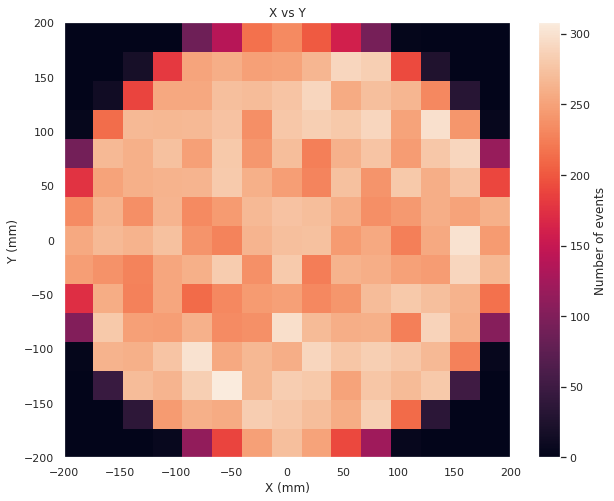

In [31]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, (-200,200), (-200,200), 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

In [35]:
bootstrap_corr_f   = file_bootstrap_map
write_filtered_dst = False
print(bootstrap_corr_f)
emaps = read_maps(filename=bootstrap_corr_f)
norm = amap_max(emaps)
norm

kr_emap_xy_100_100_r_6573_time.h5


ASectorMap(chi2=46.139179060220606, e0=13332.90552664756, lt=5019.725759445955, e0u=0.7788394012331803, ltu=12.573622097841534, mapinfo=None)

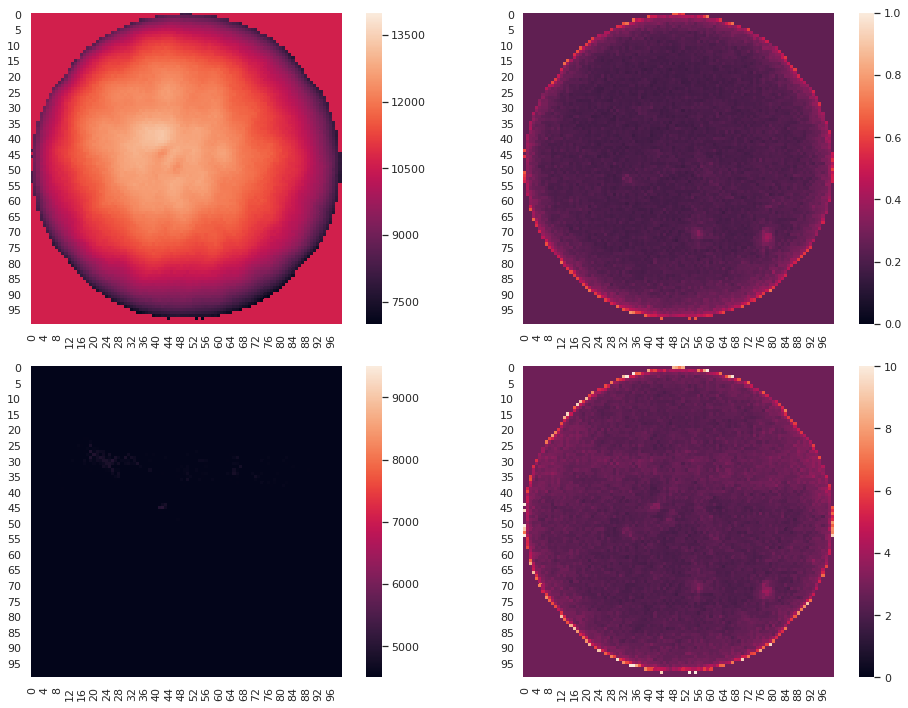

In [36]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (4500, 9500),
            eulims  = (0.0,  1),
            lulims  = (0, 10),
            figsize=(14,10))

In [37]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = 100, 
        ny  = 100)

Time spent in e0_xy_correction: 0.5505852699279785 s


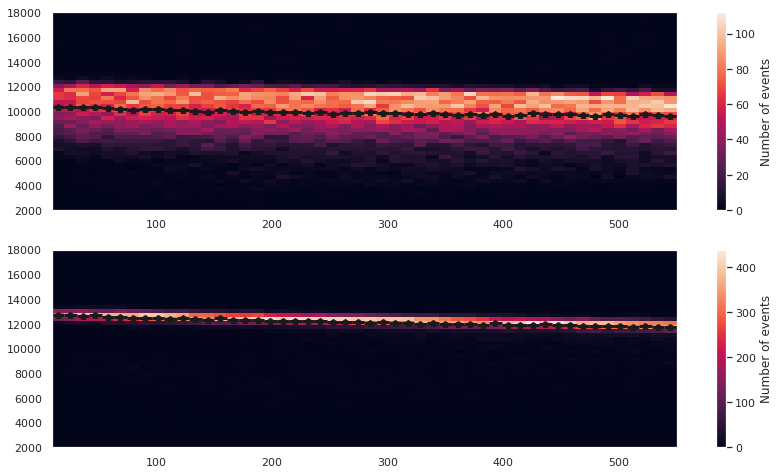

In [38]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

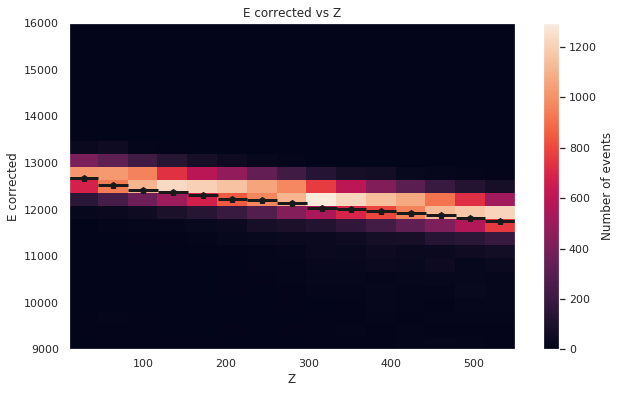

In [39]:
nevt = h2d(dst.Z, E0, krNbins.Z, krNbins.S2e, krRanges.Z, (9000,16000), 
           pltLabels=PlotLabels(x='Z', y='E corrected', title='E corrected vs Z'),
           profile=True,
           figsize=(10,6))

In [40]:
from ICAROS_master.krcal.core.selection_functions           import selection_in_band
range_krs2 = (10.0e+3,14e+3)
sel_krband, fpl, fph, hp, pp = selection_in_band(dst.Z, E0,
                                                 range_z = krRanges.Z,
                                                 range_e = range_krs2,
                                                 nbins_z = 50,
                                                 nbins_e = 50,
                                                 nsigma  = 3.5)

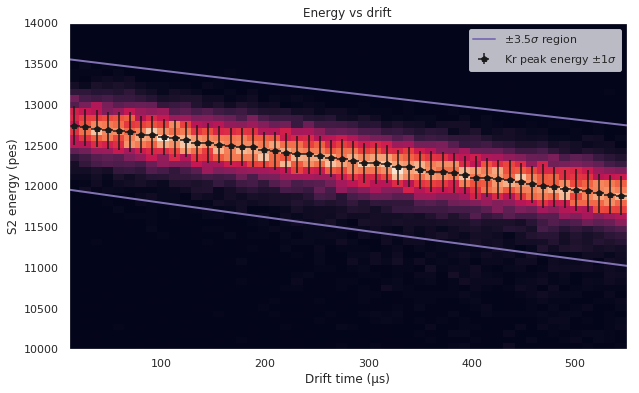

In [41]:
from ICAROS_master.krcal.core.selection_functions           import plot_selection_in_band
plot_selection_in_band(fpl, fph, hp, pp)

In [42]:
from ICAROS_master.krcal.core.selection_functions           import selection_info
selection_info(sel_krband, 'Kr band')

Total number of selected candidates Kr band: 43404 (93.8 %)


'Total number of selected candidates Kr band: 43404 (93.8 %)'

In [43]:
dst = dst.assign(E0=E0)
dsts = dst[sel_krband]

### Check dst_passed cut and dsts equal

In [62]:
columns_to_check = ['event', 'X', 'Y', 'S1e', 'S2e', 'Z']

In [64]:
np.all(dsts[columns_to_check] == dst_passed_cut[columns_to_check])

True

### Check map production...

In [66]:
xy_range

(-200, 200)

In [71]:
config_n.map_params['z_range']

(10, 550)

In [77]:
maps = calculate_map (dst      = dst_passed_cut,
                          XYbins   = (default_n_bins, default_n_bins),
                          nbins_z  = config_n.map_params['nbins_z'],
                          nbins_e  = config_n.map_params['nbins_e'],
                          z_range  = config_n.map_params['z_range'],
                          e_range  = config_n.map_params['e_range'],
                          chi2_range = config_n.map_params['chi2_range'],
                          lt_range = config_n.map_params['lt_range'],
                          fit_type = FitType.unbined,
                          nmin     = config_n.map_params['nmin'],
                          x_range  =config_n.map_params['x_range'],
                          y_range  = config_n.map_params['y_range'])
XYbins   = (default_n_bins, default_n_bins)
nbins_z  = config_n.map_params['nbins_z']
nbins_e  = config_n.map_params['nbins_e']
z_range  = config_n.map_params['z_range']
e_range  = config_n.map_params['e_range']
chi2_range = config_n.map_params['chi2_range']
lt_range = config_n.map_params['lt_range']
fit_type = FitType.unbined
nmin     = config_n.map_params['nmin']
x_range  =config_n.map_params['x_range']
y_range  = config_n.map_params['y_range']

In [114]:
columns_to_check = ['event', 'X', 'Y', 'S1e', 'S2e', 'Z']

In [116]:
import krcal
xbins_ = np.linspace(*x_range, XYbins[0]+1)
ybins_ = np.linspace(*y_range, XYbins[1]+1)
KXY_ = krcal.core.selection_functions.select_xy_sectors_df(dst_passed_cut[columns_to_check + ['time']], xbins_, ybins_)
nXY_ = event_map_df(KXY_)
fmxy_ = fit_map_xy_df(selection_map = KXY_,
                         event_map     = nXY_,
                         n_time_bins   = 1,
                         time_diffs    = dst_passed_cut.time.values,
                         nbins_z       = nbins_z,
                         nbins_e       = nbins_e,
                         range_z       = z_range,
                         range_e       = e_range,
                         energy        = 'S2e',
                         z             = 'Z',
                         fit           = fit_type,
                         n_min         = nmin)
tsm_ = tsmap_from_fmap(fmxy_)
am_  = amap_from_tsmap(tsm_,
                          ts         = 0,
                          range_e    = e_range,
                          range_chi2 = chi2_range,
                          range_lt   = lt_range)


In [104]:
KXY_[6][0]

,index,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
87,87,86,1.568379e+09,0,0,1,1,275.0,1.791020,12.609089,...,24,499.900909,499.900909,2.227926,-23.791573,-187.052173,188.559153,-1.697309,22.323335,10.558502
618,618,588,1.568379e+09,0,0,1,1,325.0,1.966111,13.026902,...,23,333.883759,333.883759,1.849581,-16.260811,-180.392914,181.124315,-1.660694,10.126185,10.942462
1554,256,1507,1.568379e+09,0,0,1,1,125.0,1.590948,5.852164,...,22,66.473442,66.473442,0.858101,-17.320498,-182.982223,183.800146,-1.665172,9.101230,9.351838
1646,348,1601,1.568379e+09,0,0,1,1,425.0,2.183731,20.170534,...,22,252.008133,252.008133,1.543733,-27.735061,-187.965109,190.000305,-1.717294,10.388137,9.836495
2624,84,2583,1.568379e+09,0,0,1,1,175.0,1.846161,8.639012,...,22,221.199570,221.199570,1.481150,-23.164797,-189.106288,190.519805,-1.692685,9.258080,9.780619
2714,172,2670,1.568379e+09,0,0,1,1,150.0,1.784056,7.497832,...,23,305.677521,305.677521,1.720463,-21.627061,-179.624546,180.921827,-1.690621,10.451530,9.642959
2847,307,2797,1.568379e+09,0,0,1,1,150.0,2.398155,10.074598,...,22,432.858032,432.858032,2.040448,-38.830936,-181.657983,185.761848,-1.781386,10.698883,10.359597
3055,513,3002,1.568379e+09,0,0,1,1,125.0,1.956420,7.271653,...,23,179.527008,179.527008,1.337528,-26.946630,-190.078852,191.979403,-1.711623,9.241692,9.873000
3182,640,3124,1.568379e+09,0,0,1,1,275.0,1.941273,10.115372,...,28,455.615906,455.615906,2.152992,-38.424317,-173.549540,177.752274,-1.788684,26.521247,15.149089
3317,132,3270,1.568379e+09,0,0,1,1,200.0,2.950258,13.944589,...,19,411.113342,411.113342,2.051838,-26.226362,-179.423439,181.330065,-1.715939,11.710250,30.675572


In [105]:
KXY_[6][0]

,index,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
87,87,86,1.568379e+09,0,0,1,1,275.0,1.791020,12.609089,...,24,499.900909,499.900909,2.227926,-23.791573,-187.052173,188.559153,-1.697309,22.323335,10.558502
618,618,588,1.568379e+09,0,0,1,1,325.0,1.966111,13.026902,...,23,333.883759,333.883759,1.849581,-16.260811,-180.392914,181.124315,-1.660694,10.126185,10.942462
1554,256,1507,1.568379e+09,0,0,1,1,125.0,1.590948,5.852164,...,22,66.473442,66.473442,0.858101,-17.320498,-182.982223,183.800146,-1.665172,9.101230,9.351838
1646,348,1601,1.568379e+09,0,0,1,1,425.0,2.183731,20.170534,...,22,252.008133,252.008133,1.543733,-27.735061,-187.965109,190.000305,-1.717294,10.388137,9.836495
2624,84,2583,1.568379e+09,0,0,1,1,175.0,1.846161,8.639012,...,22,221.199570,221.199570,1.481150,-23.164797,-189.106288,190.519805,-1.692685,9.258080,9.780619
2714,172,2670,1.568379e+09,0,0,1,1,150.0,1.784056,7.497832,...,23,305.677521,305.677521,1.720463,-21.627061,-179.624546,180.921827,-1.690621,10.451530,9.642959
2847,307,2797,1.568379e+09,0,0,1,1,150.0,2.398155,10.074598,...,22,432.858032,432.858032,2.040448,-38.830936,-181.657983,185.761848,-1.781386,10.698883,10.359597
3055,513,3002,1.568379e+09,0,0,1,1,125.0,1.956420,7.271653,...,23,179.527008,179.527008,1.337528,-26.946630,-190.078852,191.979403,-1.711623,9.241692,9.873000
3182,640,3124,1.568379e+09,0,0,1,1,275.0,1.941273,10.115372,...,28,455.615906,455.615906,2.152992,-38.424317,-173.549540,177.752274,-1.788684,26.521247,15.149089
3317,132,3270,1.568379e+09,0,0,1,1,200.0,2.950258,13.944589,...,19,411.113342,411.113342,2.051838,-26.226362,-179.423439,181.330065,-1.715939,11.710250,30.675572


In [108]:
KXY[6][0][columns_to_check]

,event,X,Y,S1e,S2e,Z
87,86,-23.791573,-187.052173,12.609089,8277.576172,499.900909
293,282,-26.557099,-187.609510,6.159855,8148.618652,329.029877
311,294,-25.139552,-193.378590,6.732681,7296.944336,769.418030
618,588,-16.260811,-180.392914,13.026902,9327.885742,333.883759
1554,1507,-17.320498,-182.982223,5.852164,9399.607422,66.473442
1646,1601,-27.735061,-187.965109,20.170534,8629.096680,252.008133
1670,1629,-31.688743,-197.363714,15.573142,4361.779297,384.529907
2624,2583,-23.164797,-189.106288,8.639012,8721.712891,221.199570
2714,2670,-21.627061,-179.624546,7.497832,9209.731445,305.677521
2847,2797,-38.830936,-181.657983,10.074598,8567.777344,432.858032


In [107]:
KXY_[6][0][columns_to_check]

,event,X,Y,S1e,S2e,Z
87,86,-23.791573,-187.052173,12.609089,8277.576172,499.900909
618,588,-16.260811,-180.392914,13.026902,9327.885742,333.883759
1554,1507,-17.320498,-182.982223,5.852164,9399.607422,66.473442
1646,1601,-27.735061,-187.965109,20.170534,8629.096680,252.008133
2624,2583,-23.164797,-189.106288,8.639012,8721.712891,221.199570
2714,2670,-21.627061,-179.624546,7.497832,9209.731445,305.677521
2847,2797,-38.830936,-181.657983,10.074598,8567.777344,432.858032
3055,3002,-26.946630,-190.078852,7.271653,8579.604492,179.527008
3182,3124,-38.424317,-173.549540,10.115372,9240.967773,455.615906
3317,3270,-26.226362,-179.423439,13.944589,8697.071289,411.113342


In [106]:
np.all(KXY_[6][0][columns_to_check] == KXY[6][0][columns_to_check])

ValueError: Can only compare identically-labeled DataFrame objects

In [117]:
ti = timeit(select_xy_sectors_df)
KXY = ti(dst[columns_to_check + ['DT']], krBins.X, krBins.Y)

Time spent in select_xy_sectors_df: 0.2693145275115967 s


In [118]:
nXY

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,7,152,270,337,360,373,258,163,7,0,0,0
1,0,0,55,320,382,347,356,376,363,327,381,285,63,0,0
2,0,68,346,355,362,395,350,360,357,339,360,364,357,61,0
3,7,328,359,345,374,350,350,333,379,389,390,380,373,312,5
4,138,357,321,318,344,321,365,384,335,355,355,297,367,347,143
5,235,345,302,360,301,308,338,360,280,327,341,349,370,349,281
6,305,308,308,333,338,368,303,370,318,361,350,334,316,373,342
7,316,366,336,347,307,300,352,349,366,337,313,298,346,382,349
8,332,346,323,363,306,359,334,368,363,337,325,304,367,334,349
9,235,316,348,347,339,351,328,323,306,360,315,355,322,353,239


In [96]:
nXY_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,2,49,129,187,208,180,131,66,0,0,0,0
1,0,0,13,189,255,253,282,278,271,256,283,186,26,0,0
2,0,12,210,259,284,308,266,283,279,251,276,266,230,14,0
3,0,206,258,273,300,256,264,259,291,275,283,277,265,182,1
4,71,272,247,246,261,233,235,295,267,259,260,226,288,257,79
5,122,256,225,253,212,231,244,248,230,241,270,279,271,263,173
6,197,237,228,253,260,281,237,280,222,263,259,249,244,289,217
7,203,265,262,273,239,228,263,273,272,244,253,225,254,297,212
8,171,262,236,264,233,244,268,274,270,259,236,243,258,251,210
9,113,245,259,263,263,280,260,247,228,273,240,280,257,274,141


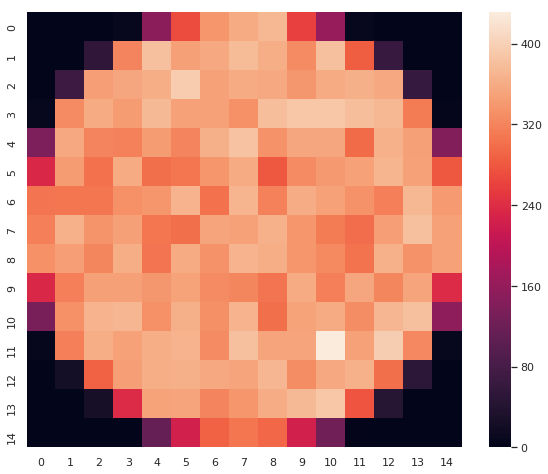

In [94]:
nXY = event_map_df(KXY)
ax = sns.heatmap(nXY, square=True)

In [49]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy = ti(selection_map = KXY,
              event_map      = nXY,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'Z',
              fit            = FitType.unbined,
              n_min          = 100)
ti = timeit(tsmap_from_fmap)
tsm = ti(fmxy)

Time spent in fit_map_xy_df: 1.716209888458252 s
Time spent in tsmap_from_fmap: 0.00021767616271972656 s


In [50]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [76]:
am.e0

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,NaN,NaN,NaN,8554.682534,9135.238771,9101.376971,8976.690544,8755.533369,8210.943598,8096.796342,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,9350.241959,9949.754622,10646.241170,10753.389532,10524.707818,10302.005252,9826.711210,9244.104574,8635.969562,NaN,NaN,NaN
2,NaN,NaN,9503.860344,10913.773710,10885.308876,11275.764632,11448.208596,11328.564032,11149.940503,10886.227571,10314.524256,9634.940445,8468.516512,NaN,NaN
3,NaN,9001.967691,10591.920676,11220.033916,11607.588328,11706.067944,12224.040835,11753.096613,11491.486584,11344.614955,10758.696127,10250.702146,9540.719292,8433.159661,NaN
4,9001.786505,10044.244907,11136.135164,11496.405726,11761.996570,11859.237101,12032.239744,11797.829722,11787.502520,11495.974077,11097.547567,10652.059278,9933.709900,9091.132583,7995.899993
5,9394.771063,10241.846703,11306.735757,11848.288937,11923.067787,12301.018950,12604.690530,12100.565473,11896.880679,11680.638249,11226.032579,10767.572697,10321.311866,9495.304550,8205.460795
6,9232.303483,10708.878123,11231.058544,11836.547999,12144.397827,12407.960481,12168.229884,12132.616344,12157.750221,11841.757058,11374.172666,11095.968802,10591.198131,9646.727346,8655.861554
7,8849.158111,10430.158961,11005.568085,11553.209586,12119.093267,12199.810421,12047.458541,12029.582497,12035.360296,11778.038640,11465.278066,11050.603411,10499.335360,9784.835624,8445.602162
8,8605.854126,10133.002617,10867.476567,11330.753294,11731.578505,12004.197006,12020.344965,12070.611161,11932.859475,11542.241389,11377.177744,10841.549789,10339.764483,9563.246071,8562.748609
9,8170.829013,9726.072306,10381.315485,11064.753875,11389.859432,11805.760065,11802.102081,11889.858236,11561.858211,11313.524311,10974.312655,10725.755445,10083.939077,9090.468646,8065.086623


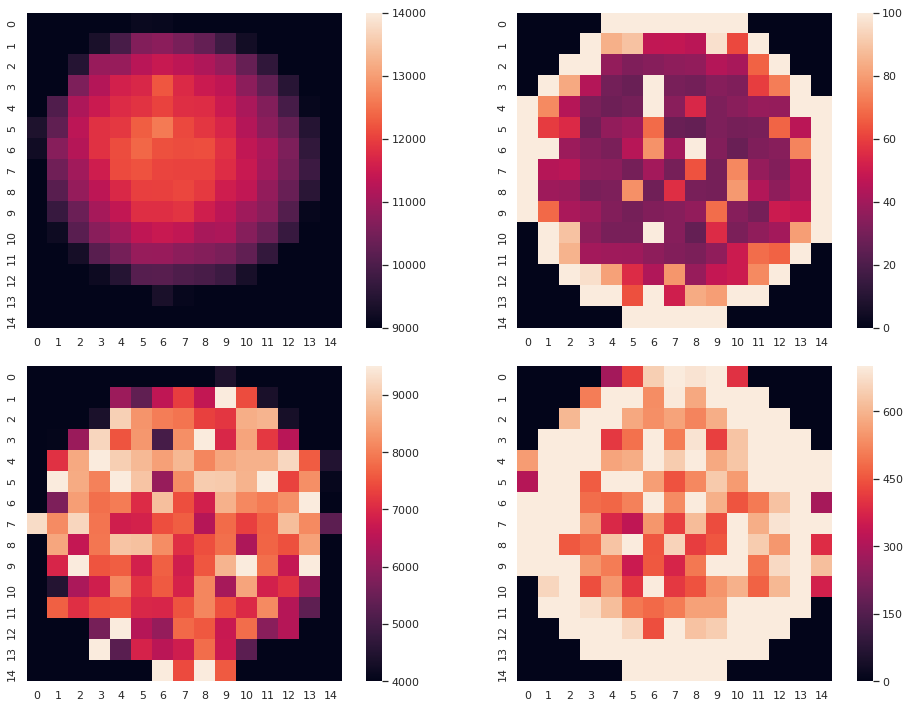

In [51]:
draw_xy_maps(am,
            e0lims  = (9000, 14000),
            ltlims  = (4000, 9500),
            eulims  = (0.0,  100),
            lulims  = (0, 700),
            figsize=(14,10))